In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math 

%matplotlib inline

In [2]:
df = pd.read_csv('../df.csv')

In [3]:
df.head()

season          title  rating  votes  double  episode  votes_norm  month  \
0       1          Pilot     7.4   7006       0        1    0.009148      3   
1       1  Diversity Day     8.3   6902       0        2    0.009012      3   
2       1    Health Care     7.7   5756       0        3    0.007516      4   
3       1   The Alliance     8.0   5579       0        4    0.007285      4   
4       1     Basketball     8.4   6183       0        5    0.008073      4   

   writer_B.J._Novak  writer_Mindy_Kaling  ...  whispering  screaming  \
0                  0                    0  ...           0          1   
1                  1                    0  ...           0          0   
2                  0                    0  ...           0          0   
3                  0                    0  ...           2          1   
4                  0                    0  ...           0          0   

   singing  applause  accent  crying  smiling  sigh  kiss  one  
0        1         0       0       1        0     1     0    1  
1        0         0       3       1        0     0     0    1  
2        0         1       0       0        0     0     0    1  
3        1         0       0       0        0     0     1    1  
4        3         2       0       0        0     0     0    1  

[5 rows x 343 columns]

In [4]:
def RMSE(y, y_pred):
    SME = sum((y - y_pred)**2)
    
    return round(math.sqrt(SME/len(y)),3)

In [473]:
import statsmodels.formula.api as smf

def linear_regression(train, test, model_features,weights=None):
    formula = 'rating ~ '

    for value in model_features:
        if value != 'rating':
            formula += value + " + "

    formula = formula[:-2]

    print(formula)
    print()
    
    if weights is not None:
        model = smf.ols(formula, data=train, weights=weights)
    else:
        model = smf.ols(formula, data=train)
        
    results = model.fit()
    
    print(results.summary())


    prediction = results.predict(test[model_features])

    fig,ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
    
    sns.scatterplot(x=test.rating.values, y=prediction.values, ax=ax[0]).set(title=f'RMSE={RMSE(test.rating.values, prediction.values)}')
    sns.lineplot(x=[7,8,9], y=[7,8,9], ax=ax[0])
    
    sns.kdeplot(prediction-test.rating,ax=ax[1]).set(title='KDE of residuals')
    sns.scatterplot(x=test.index, y=prediction-test.rating,ax=ax[2]).set(title='residuals across episodes')
    
    return results

## Delete features are not used in model

In [629]:
columns = df.columns

characters_words_total = [word for word in columns if '_words_total' in word]

In [630]:
to_drop = ['title','season','episode','month','one'] + characters_words_total

In [631]:
df_model = df.drop(columns=to_drop, axis=1)

## Rename features with dot

In [632]:
for name in df_model.columns:
    if '.' in name:
        print(name,name.replace('.','_'))
        df_model.rename(columns={name: name.replace('.','_')},inplace=True)
        
    if '-' in name:
        print(name,name.replace('-','_'))
        df_model.rename(columns={name: name.replace('-','_')},inplace=True)

writer_B.J._Novak writer_B_J__Novak
writer_Anthony_Q._Farrell writer_Anthony_Q__Farrell
writer_Nicki_Schwartz-Wright writer_Nicki_Schwartz_Wright
director_B.J._Novak director_B_J__Novak
director_Victor_Nelli_Jr. director_Victor_Nelli_Jr_
director_J.J._Abrams director_J_J__Abrams
director_Kelly_Cantley-Kashima director_Kelly_Cantley_Kashima


## train-test splittin

In [633]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_model, test_size=0.30, shuffle=True, random_state=1)

In [634]:
x_train = train.drop(columns=['rating', 'votes','votes_norm'], axis=1)
y_train = train.rating

x_test = test.drop(columns=['rating', 'votes','votes_norm'], axis=1)
y_test = test.rating

In [635]:
len(x_train)

130

<AxesSubplot:ylabel='rating'>

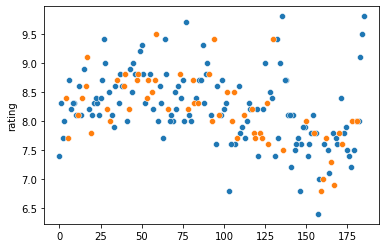

In [636]:
sns.scatterplot(x=train.index,y=train.rating)
sns.scatterplot(x=test.index,y=test.rating)

## Choosing most important properties using random forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

### tune hyperparameter with RandomizedSearchCV

In [50]:
from sklearn.model_selection import RandomizedSearchCV

In [51]:
from pprint import pprint

In [138]:
dtree = RandomForestRegressor()

In [210]:
## Number of trees in random forest
n_estimators = [50,500,100, 2000]

# Number of features to consider at every split
max_features = [None, 'sqrt', 0.3, 0.6, 0.9]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [10, 50, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 50, 100]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [10, 60, 110, None],
 'max_features': [None, 'sqrt', 0.3, 0.6, 0.9],
 'min_samples_leaf': [10, 50, 100],
 'min_samples_split': [10, 50, 100],
 'n_estimators': [50, 500, 100, 2000]}


In [211]:
rf_random = RandomizedSearchCV(estimator = dtree, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 5, verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

In [226]:
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_features=0.6,
                                                   n_estimators=50),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 60, 110, None],
                                        'max_features': [None, 'sqrt', 0.3, 0.6,
                                                         0.9],
                                        'min_samples_leaf': [10, 50, 100],
                                        'min_samples_split': [10, 50, 100],
                                        'n_estimators': [50, 500, 100, 2000]},
                   random_state=42, verbose=2)

In [227]:
print(rf_random.best_params_)

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 10, 'bootstrap': True}


### GridSearchCV

{'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 0.9, 'max_depth': 10, 'bootstrap': True}

In [214]:
from sklearn.model_selection import GridSearchCV

In [215]:
param_grid = {
    'max_depth': [ 10, 30, 50, None],
    'max_features': [0.7, 0.8, 0.9, None],
    'min_samples_split' : [5, 10, 15],
    'min_samples_leaf' : [5, 10, 15],
    'n_estimators': [500,1000, 2000]
}

In [216]:
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [217]:
grid_search.fit(x_train, y_train,sample_weight=train.votes_norm)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed: 43.2min finished


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features=0.6, n_estimators=50),
             n_jobs=-1,
             param_grid={'max_depth': [10, 30, 50, None],
                         'max_features': [0.7, 0.8, 0.9, None],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [500, 1000, 2000]},
             verbose=2)

In [218]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 0.9,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 1000}

### Fit with best param

In [289]:
dtree = RandomForestRegressor(max_features= None, 
                              n_estimators= 100,
                              min_samples_split = 10,
                              min_samples_leaf = 10,
                             max_depth=10 )
dtree.fit(x_train, y_train)

prediction = dtree.predict(x_test)

print(f"RMSE = {RMSE(y_test, prediction)}")

mean_y = test.rating.values.mean()

print(f"R2 = {round(1 - sum((test.rating.values-prediction)**2)/sum((test.rating.values-mean_y)**2),2)}")

RMSE = 0.459
R2 = 0.36


[Text(0.5, 1.0, 'residuals across episodes')]

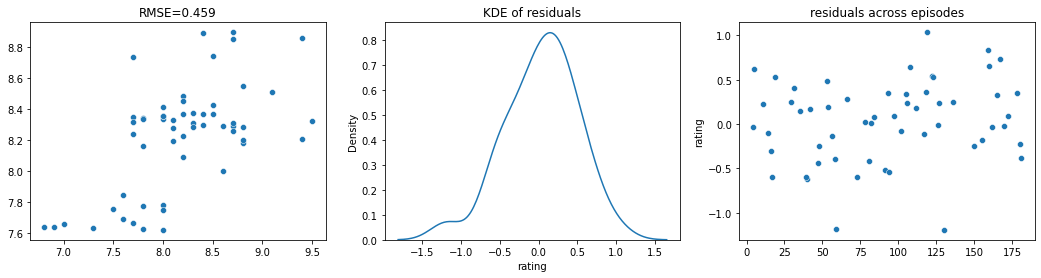

In [290]:
fig,ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)
    
sns.scatterplot(x=test.rating.values, y=prediction, ax=ax[0]).set(title=f'RMSE={RMSE(test.rating.values, prediction)}')
sns.kdeplot(prediction-test.rating,ax=ax[1]).set(title='KDE of residuals')
sns.scatterplot(x=test.index, y=prediction-test.rating,ax=ax[2]).set(title='residuals across episodes')

<AxesSubplot:xlabel='Importance', ylabel='Variable'>

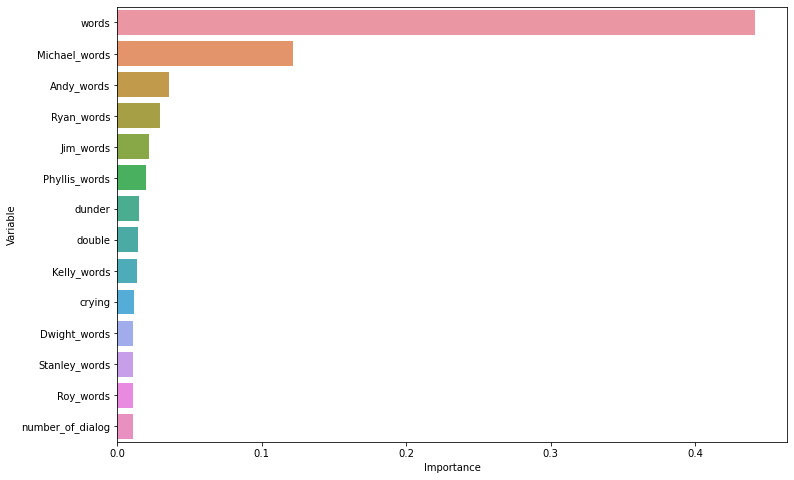

In [291]:
importance = pd.DataFrame({'Variable':train.drop(columns=['rating', 'votes','votes_norm'], axis=1).columns,
              'Importance':grid_search.best_estimator_.feature_importances_}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(x=importance[importance.Importance > 0.01].Importance, y=importance[importance.Importance > 0.01].Variable)

## Linear regression

In [284]:
importance = pd.DataFrame({'Variable':x_train.columns,
              'Importance':dtree.feature_importances_}).sort_values('Importance', ascending=False)

In [235]:
importance[:20]

Variable  Importance
96                words    0.269008
97        Michael_words    0.255114
101          Andy_words    0.089895
106          Ryan_words    0.046263
108       Phyllis_words    0.029777
109         Kelly_words    0.024809
271              dunder    0.020184
286               death    0.017941
268    number_of_dialog    0.017718
99            Jim_words    0.017466
303                sigh    0.015087
280                love    0.011938
267  dialog_mean_length    0.010213
128    Jim_about_Dwight    0.010208
200    Andy_Erin_dialog    0.009868
115        Nellie_words    0.008650
273               sales    0.008343
270            scranton    0.008274
134  Jim_Michael_dialog    0.008192
282               paper    0.007805

### find square dependencies

In [237]:
from sklearn import linear_model

In [236]:
from sklearn.model_selection import cross_validate

In [507]:
ols = linear_model.LinearRegression()

In [265]:
num_features = 20

In [270]:
cv_results = cross_validate(ols, x_train[importance.iloc[:num_features].Variable], y_train, cv=10,scoring=('r2', 'neg_root_mean_squared_error'))
print(f"all linear: r2={round(cv_results['test_r2'].mean(),2)}, RMSE={round(cv_results['test_neg_root_mean_squared_error'].mean(),2)}")

all linear: r2=0.11, RMSE=-0.52


In [325]:

results = {}
for feature in importance.iloc[:num_features].Variable:
    X = x_train[importance.iloc[:num_features].Variable].copy(deep = True)
    X[feature] = X[feature].apply(lambda x: x*x)
    
    cv_results = cross_validate(ols, X, y_train, cv=10,scoring=('r2', 'neg_root_mean_squared_error'))
    
    results.update({feature: {'r2':round(cv_results['test_r2'].mean(),2), 'RMSE': round(cv_results['test_neg_root_mean_squared_error'].mean(),2)}})

In [326]:
results

{'words': {'r2': 0.01, 'RMSE': -0.55},
 'Michael_words': {'r2': -0.05, 'RMSE': -0.56},
 'Andy_words': {'r2': 0.01, 'RMSE': -0.54},
 'Ryan_words': {'r2': 0.01, 'RMSE': -0.54},
 'Jim_words': {'r2': 0.01, 'RMSE': -0.54},
 'Phyllis_words': {'r2': 0.01, 'RMSE': -0.54},
 'dunder': {'r2': 0.02, 'RMSE': -0.54},
 'double': {'r2': 0.02, 'RMSE': -0.54},
 'Kelly_words': {'r2': 0.02, 'RMSE': -0.54},
 'crying': {'r2': 0.03, 'RMSE': -0.54},
 'Dwight_words': {'r2': 0.01, 'RMSE': -0.54},
 'Stanley_words': {'r2': 0.02, 'RMSE': -0.54},
 'Roy_words': {'r2': 0.01, 'RMSE': -0.55},
 'number_of_dialog': {'r2': 0.02, 'RMSE': -0.54},
 'dialog_mean_length': {'r2': 0.01, 'RMSE': -0.54},
 'Erin_words': {'r2': 0.03, 'RMSE': -0.54},
 'love': {'r2': -0.03, 'RMSE': -0.55},
 'scranton': {'r2': 0.0, 'RMSE': -0.55},
 'Jim_about_Pam': {'r2': 0.02, 'RMSE': -0.54},
 'stupid': {'r2': -0.09, 'RMSE': -0.56}}

In [323]:
importance.iloc[:num_features].Variable

96                  words
97          Michael_words
101            Andy_words
106            Ryan_words
99              Jim_words
108         Phyllis_words
271                dunder
0                  double
109           Kelly_words
301                crying
98           Dwight_words
112         Stanley_words
123             Roy_words
268      number_of_dialog
267    dialog_mean_length
104            Erin_words
280                  love
270              scranton
127         Jim_about_Pam
272                stupid
Name: Variable, dtype: object

In [327]:
X = x_train[importance.iloc[:num_features].Variable].copy(deep = True)

for feature in importance.iloc[:num_features].Variable:
    X1 = X.copy(deep=True)
    X2 = X.copy(deep=True)
    
    X2[feature] = X[feature].apply(lambda x: x*x)
    X2.rename(columns={feature: feature+'_sqrt'},inplace=True)
    
    cv1 = cross_validate(ols, X1, y_train, cv=10,scoring=('r2', 'neg_root_mean_squared_error'))
    cv2 = cross_validate(ols, X2, y_train, cv=10,scoring=('r2', 'neg_root_mean_squared_error'))
    
    if abs(cv1['test_neg_root_mean_squared_error'].mean()) > abs(cv2['test_neg_root_mean_squared_error'].mean()):
        X = X2.copy(deep=True)
    else:
        X=X1

In [322]:
for name in X.columns:
    if '_sqrt' in name:
        print(name)

crying_sqrt
Erin_words_sqrt
Jim_about_Pam_sqrt


In [316]:
test_2 = x_test[importance.iloc[:num_features].Variable].copy(deep = True)

for feature in X.columns:
    if '_sqrt' in feature:
        old_name = feature.replace('_sqrt','')
        test_2[old_name] = test_2[old_name].apply(lambda x: x*x)
        test_2.rename(columns={old_name:feature},inplace=True)

In [318]:
X['rating'] = y_train
test_2['rating'] = y_test

rating ~ words + Michael_words + Andy_words + Ryan_words + Jim_words + Phyllis_words + dunder + double + Kelly_words + crying_sqrt + Dwight_words + Stanley_words + Roy_words + number_of_dialog + dialog_mean_length + Erin_words_sqrt + love + scranton + Jim_about_Pam_sqrt + stupid 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     4.925
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           2.19e-08
Time:                        19:10:51   Log-Likelihood:                -81.547
No. Observations:                 130   AIC:                             205.1
Df Residuals:                     109   BIC:                             265.3
Df Model:                          20                                         
Covaria

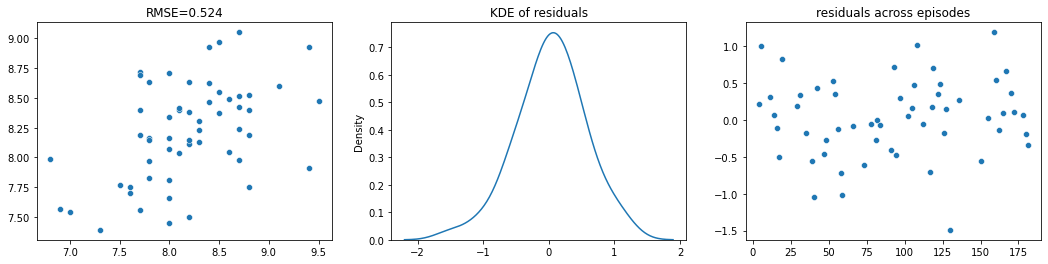

In [319]:
linear_regression(X, test_2, X.columns)

rating ~ words + Michael_words + Andy_words + Ryan_words + Jim_words + Phyllis_words + dunder + double + Kelly_words + crying + Dwight_words + Stanley_words + Roy_words + number_of_dialog + dialog_mean_length + Erin_words + love + scranton + Jim_about_Pam + stupid + laughing + money + death + whispering + Jim_Pam_dialog + Jim_about_Dwight + Angela_words + office + Toby_words + Meredith_words + Nellie_words + Jim_Michael_dialog + Pam_words + sigh + Pam_about_Michael + sales + Dwight_Michael_dialog + Kevin_words + paper + Michael_Ryan_dialog + Michael_Pam_dialog + wedding + Andy_Erin_dialog + Creed_words + date + Oscar_words + leaving + christmas + meeting + hate 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     3.073
Date:       

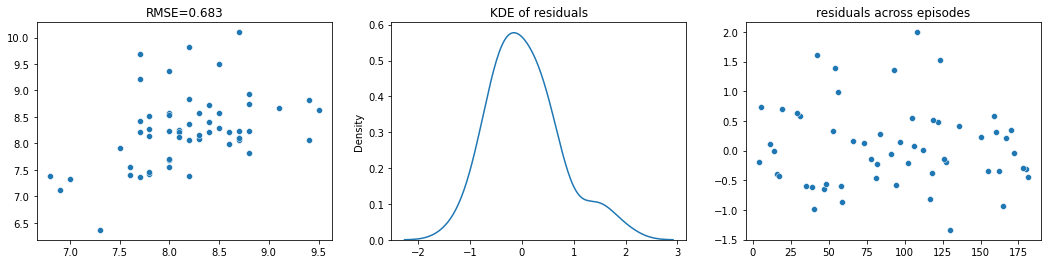

In [297]:
features_tree = importance[:50].Variable.values
res = linear_regression(train, test, features_tree)

rating ~ words + Michael_words + Andy_words + Ryan_words + Jim_words + Phyllis_words + dunder + double + Kelly_words + crying + Dwight_words + Stanley_words + Roy_words + number_of_dialog + dialog_mean_length + Erin_words + love + scranton + Jim_about_Pam + stupid 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     4.989
Date:                Wed, 02 Feb 2022   Prob (F-statistic):           1.66e-08
Time:                        18:55:08   Log-Likelihood:                -81.145
No. Observations:                 130   AIC:                             204.3
Df Residuals:                     109   BIC:                             264.5
Df Model:                          20                                         
Covariance Type:      

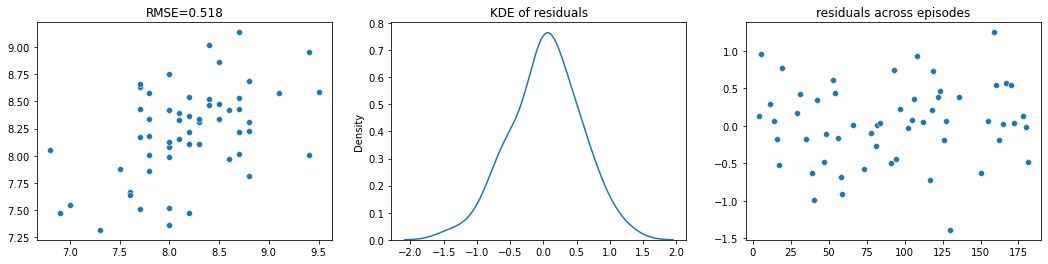

In [298]:
features_tree = importance[:20].Variable.values
res = linear_regression(train,test, features_tree)

# Lasso

In [333]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

## Scaling

In [661]:
def Michael_words_in_the_end(df):
    mv = df.Michael_words
    df.drop(columns='Michael_words', axis=1,inplace=True)
    df['Michael_words'] = mv
    
    df.drop(columns='Nellie_words', axis=1,inplace=True)
    return df

In [662]:
x_train = Michael_words_in_the_end(x_train)
x_test = Michael_words_in_the_end(x_test)

In [663]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(x_train)
y_scaler.fit(y_train.values.reshape(-1,1))

StandardScaler()

In [664]:
x_train.columns

Index(['double', 'writer_B_J__Novak', 'writer_Mindy_Kaling',
       'writer_Gene_Stupnitsky', 'writer_Justin_Spitzer',
       'writer_Brent_Forrester', 'writer_Jennifer_Celotta',
       'writer_Michael_Schur', 'writer_Warren_Lieberstein',
       'writer_Halsted_Sullivan',
       ...
       'whispering', 'screaming', 'singing', 'applause', 'accent', 'crying',
       'smiling', 'sigh', 'kiss', 'Michael_words'],
      dtype='object', length=304)

In [665]:
x_train_scaled = pd.DataFrame(x_scaler.transform(x_train), columns = x_train.columns)
y_train_scaled = np.ravel(y_scaler.transform(y_train.values.reshape(-1,1)))

x_test_scaled = pd.DataFrame(x_scaler.transform(x_test), columns = x_test.columns)
y_test_scaled = np.ravel(y_scaler.transform(y_test.values.reshape(-1,1)))

In [666]:
x_train.describe()

double  writer_B_J__Novak  writer_Mindy_Kaling  \
count  130.000000         130.000000           130.000000   
mean     0.084615           0.092308             0.084615   
std      0.279385           0.290580             0.279385   
min      0.000000           0.000000             0.000000   
25%      0.000000           0.000000             0.000000   
50%      0.000000           0.000000             0.000000   
75%      0.000000           0.000000             0.000000   
max      1.000000           1.000000             1.000000   

       writer_Gene_Stupnitsky  writer_Justin_Spitzer  writer_Brent_Forrester  \
count              130.000000             130.000000              130.000000   
mean                 0.046154               0.069231                0.061538   
std                  0.210630               0.254828                0.241245   
min                  0.000000               0.000000                0.000000   
25%                  0.000000               0.000000                0.000000   
50%                  0.000000               0.000000                0.000000   
75%                  0.000000               0.000000                0.000000   
max                  1.000000               1.000000                1.000000   

       writer_Jennifer_Celotta  writer_Michael_Schur  \
count               130.000000            130.000000   
mean                  0.053846              0.061538   
std                   0.226587              0.241245   
min                   0.000000              0.000000   
25%                   0.000000              0.000000   
50%                   0.000000              0.000000   
75%                   0.000000              0.000000   
max                   1.000000              1.000000   

       writer_Warren_Lieberstein  writer_Halsted_Sullivan  ...  whispering  \
count                 130.000000               130.000000  ...  130.000000   
mean                    0.046154                 0.046154  ...    1.261538   
std                     0.210630                 0.210630  ...    1.705231   
min                     0.000000                 0.000000  ...    0.000000   
25%                     0.000000                 0.000000  ...    0.000000   
50%                     0.000000                 0.000000  ...    1.000000   
75%                     0.000000                 0.000000  ...    2.000000   
max                     1.000000                 1.000000  ...    8.000000   

        screaming     singing    applause      accent      crying     smiling  \
count  130.000000  130.000000  130.000000  130.000000  130.000000  130.000000   
mean     0.353846    1.723077    0.853846    0.392308    0.700000    0.630769   
std      0.702835    2.131402    1.294661    1.557658    1.224112    1.694215   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    2.000000    1.000000    0.000000    1.000000    1.000000   
max      4.000000   14.000000    7.000000   16.000000    6.000000   15.000000   

             sigh        kiss  Michael_words  
count  130.000000  130.000000     130.000000  
mean     0.892308    0.707692      25.439255  
std      1.387911    1.171007      17.637445  
min      0.000000    0.000000       0.000000  
25%      0.000000    0.000000       0.000000  
50%      0.000000    0.000000      31.290873  
75%      1.000000    1.000000      39.153918  
max      7.000000    6.000000      55.563584  

[8 rows x 304 columns]

In [647]:
x_train_scaled.describe()

double  writer_B_J__Novak  writer_Mindy_Kaling  \
count  1.300000e+02       1.300000e+02         1.300000e+02   
mean  -1.024821e-16      -8.540177e-17        -8.710981e-17   
std    1.003868e+00       1.003868e+00         1.003868e+00   
min   -3.040345e-01      -3.188964e-01        -3.040345e-01   
25%   -3.040345e-01      -3.188964e-01        -3.040345e-01   
50%   -3.040345e-01      -3.188964e-01        -3.040345e-01   
75%   -3.040345e-01      -3.188964e-01        -3.040345e-01   
max    3.289100e+00       3.135815e+00         3.289100e+00   

       writer_Gene_Stupnitsky  writer_Justin_Spitzer  writer_Brent_Forrester  \
count            1.300000e+02           1.300000e+02            1.300000e+02   
mean            -1.054712e-16           7.686159e-18            6.832142e-18   
std              1.003868e+00           1.003868e+00            1.003868e+00   
min             -2.199707e-01          -2.727273e-01           -2.560738e-01   
25%             -2.199707e-01          -2.727273e-01           -2.560738e-01   
50%             -2.199707e-01          -2.727273e-01           -2.560738e-01   
75%             -2.199707e-01          -2.727273e-01           -2.560738e-01   
max              4.546061e+00           3.666667e+00            3.905125e+00   

       writer_Jennifer_Celotta  writer_Michael_Schur  \
count             1.300000e+02          1.300000e+02   
mean              1.366428e-17         -5.124106e-17   
std               1.003868e+00          1.003868e+00   
min              -2.385594e-01         -2.560738e-01   
25%              -2.385594e-01         -2.560738e-01   
50%              -2.385594e-01         -2.560738e-01   
75%              -2.385594e-01         -2.560738e-01   
max               4.191829e+00          3.905125e+00   

       writer_Warren_Lieberstein  writer_Halsted_Sullivan  ...    whispering  \
count               1.300000e+02             1.300000e+02  ...  1.300000e+02   
mean               -1.327998e-16            -1.327998e-16  ...  8.881784e-17   
std                 1.003868e+00             1.003868e+00  ...  1.003868e+00   
min                -2.199707e-01            -2.199707e-01  ... -7.426671e-01   
25%                -2.199707e-01            -2.199707e-01  ... -7.426671e-01   
50%                -2.199707e-01            -2.199707e-01  ... -1.539676e-01   
75%                -2.199707e-01            -2.199707e-01  ...  4.347320e-01   
max                 4.546061e+00             4.546061e+00  ...  3.966929e+00   

          screaming       singing      applause        accent        crying  \
count  1.300000e+02  1.300000e+02  1.300000e+02  1.300000e+02  1.300000e+02   
mean  -2.135044e-17 -5.465713e-17 -1.451830e-17 -1.058982e-16 -1.878839e-17   
std    1.003868e+00  1.003868e+00  1.003868e+00  1.003868e+00  1.003868e+00   
min   -5.054030e-01 -8.115516e-01 -6.620645e-01 -2.528318e-01 -5.740554e-01   
25%   -5.054030e-01 -8.115516e-01 -6.620645e-01 -2.528318e-01 -5.740554e-01   
50%   -5.054030e-01 -3.405618e-01 -6.620645e-01 -2.528318e-01 -5.740554e-01   
75%    9.229098e-01  1.304279e-01  1.133264e-01 -2.528318e-01  2.460237e-01   
max    5.207848e+00  5.782305e+00  4.765671e+00  1.005874e+01  4.346419e+00   

            smiling          sigh          kiss  Michael_words  
count  1.300000e+02  1.300000e+02  1.300000e+02   1.300000e+02  
mean   4.419542e-17 -2.732857e-17 -2.391250e-17   3.947697e-16  
std    1.003868e+00  1.003868e+00  1.003868e+00   1.003868e+00  
min   -3.737480e-01 -6.454013e-01 -6.066828e-01  -1.447923e+00  
25%   -3.737480e-01 -6.454013e-01 -6.066828e-01  -1.447923e+00  
50%   -3.737480e-01 -6.454013e-01 -6.066828e-01   3.330559e-01  
75%    2.187793e-01  7.789326e-02  2.505864e-01   7.805960e-01  
max    8.514161e+00  4.417661e+00  4.536932e+00   1.714583e+00  

[8 rows x 305 columns]

In [431]:
y_train_scaled.mean(),y_train_scaled.std()

(-7.242070191401021e-16, 1.0)

In [432]:
y_test_scaled.mean(),y_test_scaled.std()

(-0.0585355865309267, 0.913640648685347)

## fitting

In [667]:
lasso_cv = LassoCV()
lasso_cv.fit(x_train_scaled, y_train_scaled)

LassoCV()

In [668]:
prediction =  lasso_cv.predict(x_test_scaled)

In [669]:
np.sqrt(mean_squared_error(y_test_scaled, prediction))

0.8549107426011306

In [670]:
lasso_cv.score(x_test_scaled, y_test_scaled)

0.12443030442201808

In [671]:
lasso_cv.alpha_

0.06487845049758115

In [672]:
important_features = []
for name, val in sorted(zip(x_train.columns,lasso_cv.coef_),key=lambda x: abs(x[1]), reverse=True):
    if val != 0:
        important_features.append(name)
        
    if abs(val) > 0.01 :
        print(round(val,3), name)
        

0.208 crying
0.174 double
0.125 number_of_dialog
0.111 Charles_words
-0.111 writer_Jason_Kessler
-0.098 Dwight_Oscar_dialog
0.097 Michael_words
-0.094 Andy_words
-0.087 Oscar_Phyllis_dialog
-0.083 Jim_Nellie_dialog
-0.081 Erin_words
0.07 writer_Jennifer_Celotta
0.065 writer_Jon_Vitti
0.064 writer_Nicki_Schwartz_Wright
0.054 Darryl_Erin_dialog
-0.053 Nellie_Pam_dialog
-0.052 writer_Allison_Silverman
-0.052 Dwight_Nellie_dialog
-0.05 Angela_Oscar_dialog
0.049 Michael_Phyllis_dialog
-0.048 director_John_Krasinski
0.046 writer_Paul_Lieberstein
0.044 director_Joss_Whedon
0.041 Darryl_Michael_dialog
0.04 Erin_Jim_dialog
0.04 writer_Steve_Carell
0.038 wedding
-0.036 writer_Peter_Ocko
0.033 Jim_about_Dwight
0.032 death
0.032 accent
-0.031 Andy_Pam_dialog
-0.03 director_Randall_Einhorn
0.03 director_Steve_Carell
0.029 dundies
-0.027 writer_Amelie_Gillette
0.023 director_Harold_Ramis
0.019 Dwight_Kevin_dialog
0.017 Angela_Michael_dialog
-0.016 Andy_Darryl_dialog
-0.015 writer_Aaron_Shure
0.015 E

In [673]:
prediction_real = y_scaler.inverse_transform(prediction)

In [674]:
np.sqrt(mean_squared_error(y_test, prediction_real))

0.5344457663979525

[Text(0.5, 1.0, 'residuals across episodes')]

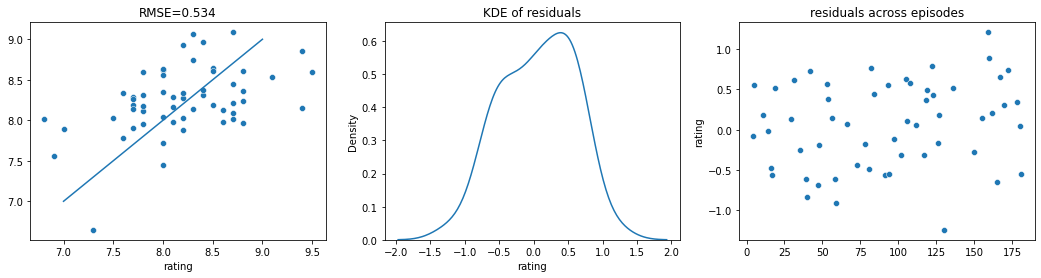

In [675]:
fig,ax = plt.subplots(figsize=(18,4), nrows=1, ncols=3)

sns.scatterplot(x=y_test, y=prediction_real, ax=ax[0]).set(title=f'RMSE={RMSE(y_test, prediction_real)}')
sns.lineplot(x=[7,8,9], y=[7,8,9], ax=ax[0])
sns.kdeplot(prediction_real - y_test,ax=ax[1]).set(title='KDE of residuals')
sns.scatterplot(x=y_test.index, y=prediction_real - y_test,ax=ax[2]).set(title='residuals across episodes')

## Linear model

rating ~ crying + Nellie_words + double + Charles_words + writer_Jason_Kessler + Dwight_Oscar_dialog + number_of_dialog + Andy_words + writer_Jennifer_Celotta + writer_Allison_Silverman + director_John_Krasinski + writer_Amelie_Gillette + writer_Jon_Vitti + writer_Nicki_Schwartz_Wright + death + Nellie_Pam_dialog + Darryl_Erin_dialog + Michael_Phyllis_dialog + writer_Paul_Lieberstein + Angela_Erin_dialog + director_Joss_Whedon + Angela_Oscar_dialog + Oscar_Phyllis_dialog + writer_Peter_Ocko + writer_Steve_Carell + Clark_words + dundies + Robert_words + wedding + Darryl_Michael_dialog + director_Randall_Einhorn + director_Harold_Ramis + Jim_about_Dwight + accent + director_Steve_Carell + Erin_Jim_dialog + Angela_Michael_dialog + Roy_words + director_Jason_Reitman + Andy_Darryl_dialog + Kevin_Oscar_dialog + Andy_Ryan_dialog + Michael_Toby_dialog + Kelly_Meredith_dialog + Holly_Phyllis_dialog + writer_Aaron_Shure + David_words + Erin_Gabe_dialog + director_Paul_Feig + director_Paul_Lieber

strong multicollinearity problems or that the design matrix is singular.


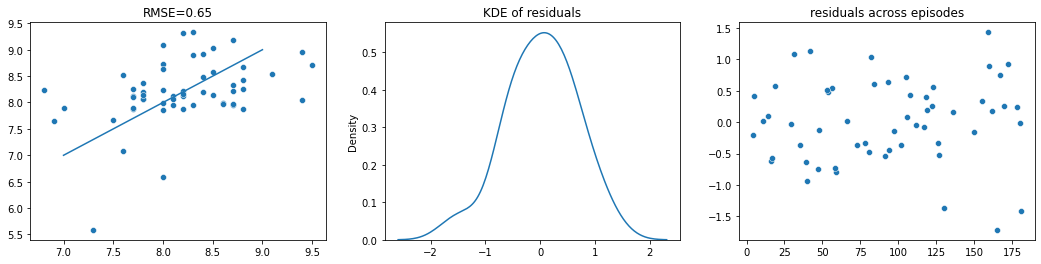

In [511]:
res = linear_regression(train,test, important_features)

In [678]:
rmse_mean, rmse_std, r2_mean, r2_std = [],[],[],[]

for num in range(1,len(important_features)):

    cv = cross_validate(ols, x_train[important_features[:num]], y_train.values, cv=5,scoring=('r2', 'neg_root_mean_squared_error'))
    
    rmse_mean.append(-1*(cv['test_neg_root_mean_squared_error'].mean()))
    rmse_std.append((cv['test_neg_root_mean_squared_error'].std()))
    
    r2_mean.append(cv['test_r2'].mean())
    r2_std.append(cv['test_r2'].std())
    

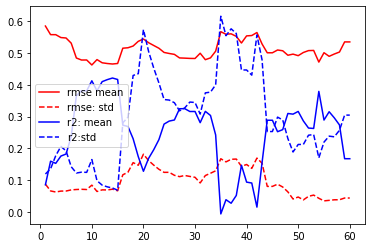

In [679]:
sns.lineplot(x=range(1,len(important_features)), y=rmse_mean, color='red', linestyle='-' )
sns.lineplot(x=range(1,len(important_features)), y=rmse_std, color='red', linestyle='--')

plt.legend([])
sns.lineplot(x=range(1,len(important_features)), y=r2_mean, color='blue' )

sns.lineplot(x=range(1,len(important_features)), y=r2_std, color='blue', linestyle='--')
plt.legend(['rmse mean','rmse: std','r2: mean',  'r2:std'])

In [601]:
np.where(rmse_mean == min(rmse_mean))

(array([29], dtype=int64),)

In [602]:
np.where(r2_mean == max(r2_mean))

(array([29], dtype=int64),)

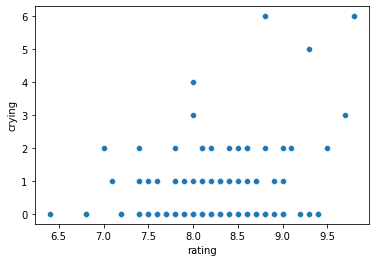

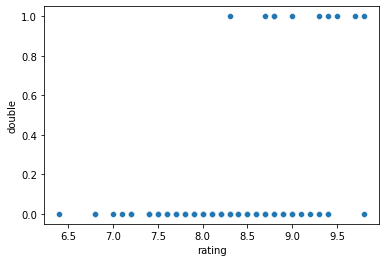

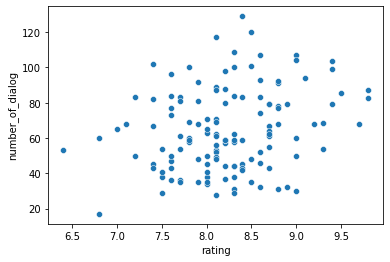

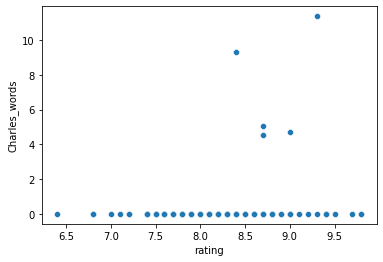

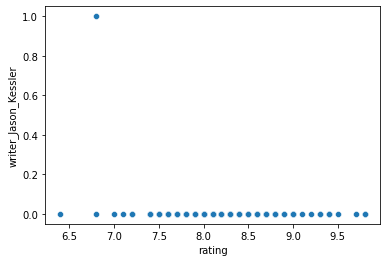

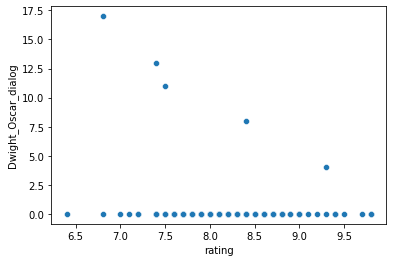

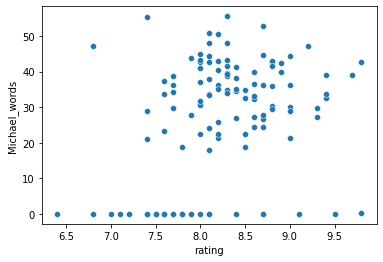

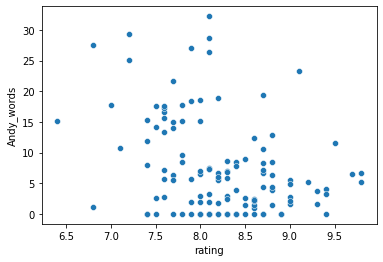

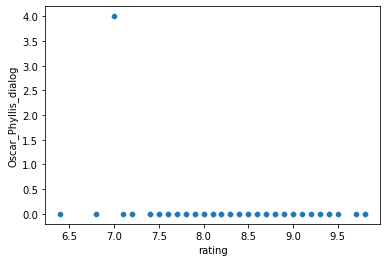

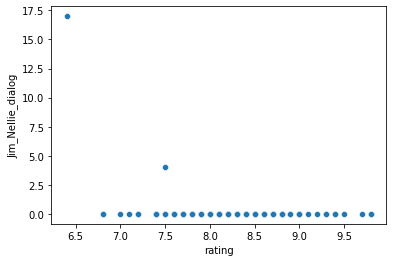

In [676]:
for feat in important_features[:10]:
    plt.figure(figsize=[ 6,4])
    sns.scatterplot(x=train.rating, y=train[feat])
    

rating ~ crying + double + number_of_dialog + Charles_words + writer_Jason_Kessler + Dwight_Oscar_dialog + Michael_words 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     17.05
Date:                Thu, 03 Feb 2022   Prob (F-statistic):           1.42e-15
Time:                        19:27:58   Log-Likelihood:                -79.047
No. Observations:                 130   AIC:                             174.1
Df Residuals:                     122   BIC:                             197.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975

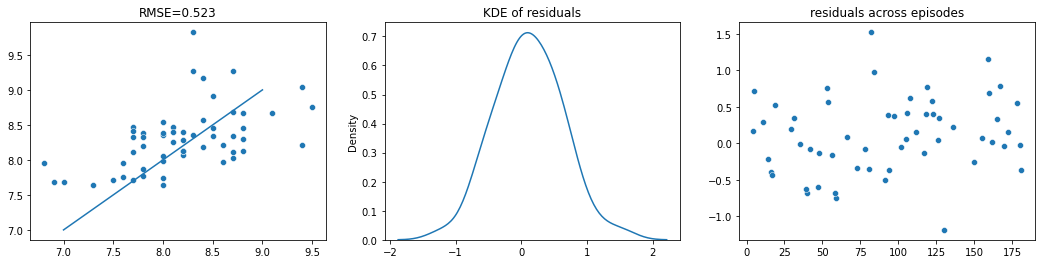

In [687]:
linear_regression(train,test, important_features[:7])

In [685]:
del_list = ['Andy_words']
choosed_features = [word for word in important_features[:10] if word not in del_list]

rating ~ crying + double + number_of_dialog + Charles_words + writer_Jason_Kessler + Dwight_Oscar_dialog + Michael_words + Oscar_Phyllis_dialog + Jim_Nellie_dialog 

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     16.28
Date:                Thu, 03 Feb 2022   Prob (F-statistic):           3.40e-17
Time:                        19:27:29   Log-Likelihood:                -71.523
No. Observations:                 130   AIC:                             163.0
Df Residuals:                     120   BIC:                             191.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err  

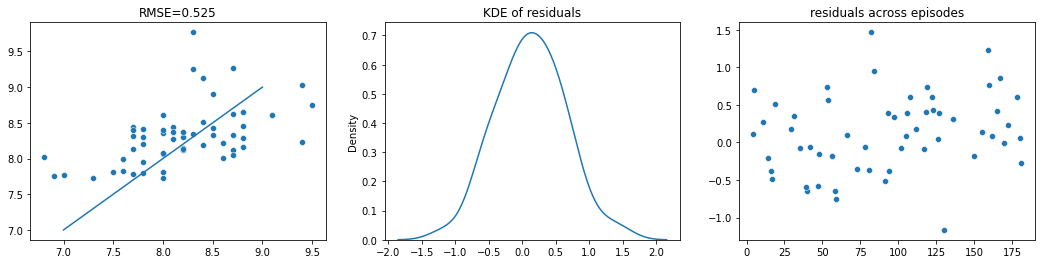

In [686]:
linear_regression(train,test, choosed_features)